## COGS 181 Final Project

Anni Li

### Description

### Environment Preparation

In [65]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [23]:
# unzip the dataset
!tar -xvzf CUB_200_2011.tgz

attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

In [66]:
# set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: GeForce GTX 1080 Ti


In [67]:
# avoid CUDA errors
CUDA_LAUNCH_BLOCKING=1

### Data Processing

#### Combine the necessary .txt files in the dataset package into one data frame

In [68]:
labels = pd.read_csv("CUB_200_2011/image_class_labels.txt", header=None, sep = " ")
labels.columns = ["id", "label"]

In [69]:
species = pd.read_csv("CUB_200_2011/classes.txt", header=None, sep = " ")
species.columns = ["label", "species"]

In [70]:
train_test = pd.read_csv("CUB_200_2011/train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]

In [71]:
image_names = pd.read_csv("CUB_200_2011/images.txt", header=None, sep=" ")
image_names.columns = ["id", "image_name"]

In [72]:
classes = pd.read_csv("CUB_200_2011/classes.txt", header=None, sep = " ")
classes.columns = ["label", "species"]
classes["label"] = classes["label"] - 1
classes

,label,species
0,0,001.Black_footed_Albatross
1,1,002.Laysan_Albatross
2,2,003.Sooty_Albatross
3,3,004.Groove_billed_Ani
4,4,005.Crested_Auklet
...,...,...
195,195,196.House_Wren
196,196,197.Marsh_Wren
197,197,198.Rock_Wren
198,198,199.Winter_Wren


In [73]:
data = pd.merge(image_names, train_test, on="id")
data = pd.merge(data, labels, on="id")
data = pd.merge(data, species, on="label")
data["label"] = data["label"] - 1
data

,id,image_name,is_train,label,species
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,0,001.Black_footed_Albatross
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,0,001.Black_footed_Albatross
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,001.Black_footed_Albatross
...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,199,200.Common_Yellowthroat
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,199,200.Common_Yellowthroat
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,199,200.Common_Yellowthroat
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,199,200.Common_Yellowthroat


#### Define the dataset class and necessary data processing functions

In [74]:
class CUBdata(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = Image.open( "CUB_200_2011/images/" + self.data.loc[index, "image_name"]).convert("RGB")
        label = self.data.loc[index, "label"]
        if self.transform is not None:
            image = self.transform(image)
            image = normalize_image(image)
        return image, label

In [75]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

In [76]:
def normalize_image(tensorimage):
    image_min = tensorimage.min()
    image_max = tensorimage.max()
    tensorimage.clamp_(min=image_min, max=image_max)
    tensorimage.add_(-image_min).div_(image_max - image_min + 1e-5)
    return tensorimage

#### Plot some images with labels to have a look

In [77]:
def plot_images(images, labels, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig, axs = plt.subplots(rows, cols, figsize = (15,15))
    axs = axs.ravel() 
    for i in range(rows*cols):
        image = Image.open("CUB_200_2011/images/" + images[i]).convert('RGB')
        image = transform(image)
        if normalize:
            image = normalize_image(image)
        image = image.numpy()
        
        axs[i].imshow(np.transpose(image, (1, 2, 0)))
        label = labels[i]
        axs[i].set_title(label)
        axs[i].set_axis_off()

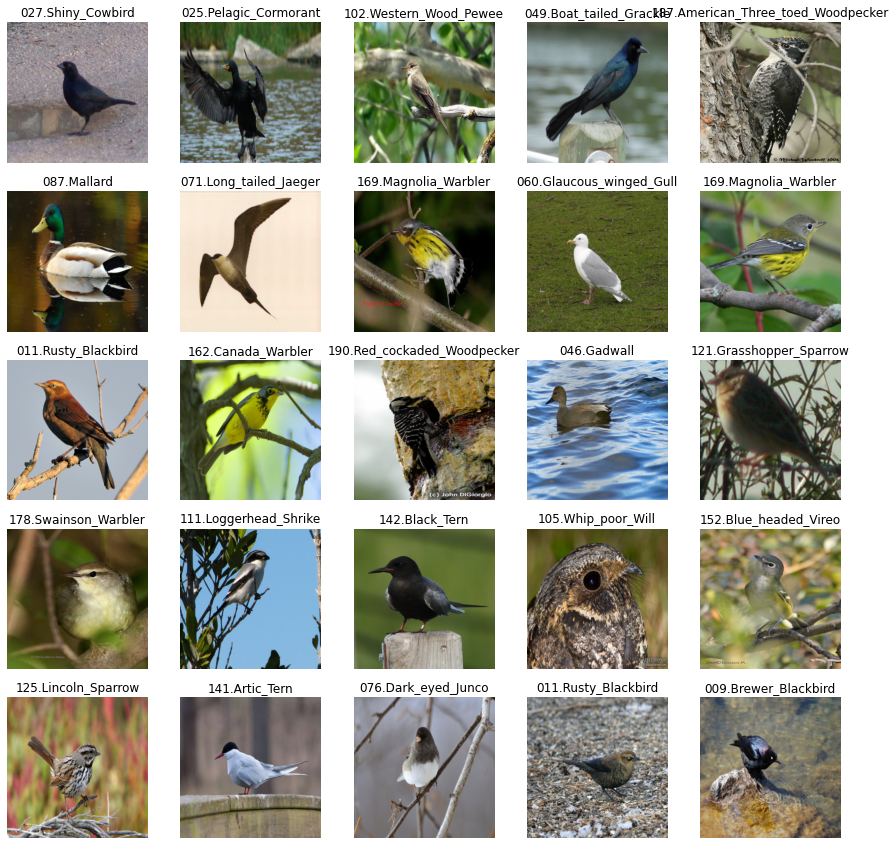

In [78]:
imagelist = []
labellist = []
randomlist = [random.randint(0, len(data)) for _ in range(25)]
for i in randomlist:
    imagelist.append(data.loc[i, 'image_name'])
    labellist.append(data.loc[i, 'species'])
plot_images(imagelist, labellist)

#### Define the data loader and CNN model

In [79]:
train_data = data[data["is_train"] == 1]
train_data = train_data.reset_index(drop=True)
trainset = CUBdata(train_data, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

test_data = data[data["is_train"] == 0]
test_data = test_data.reset_index(drop=True)
testset = CUBdata(test_data, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

In [80]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(32 * 112 * 112, 200)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x

In [81]:
net = Net()
net.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### Training

In [82]:
avg_losses = []
# set num_epoch to 1 temporary as the speed is too slow
num_epoch = 1
print_freq = 500

for epoch in range(num_epoch):
    running_loss = 0.0
    for i, trainstat in enumerate(trainloader, 0):
        inputs, ytrue = trainstat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_func(outputs, ytrue)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        if i % print_freq == (print_freq-1):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_freq))
            # append to avg_losses
            avg_losses.append(running_loss / print_freq)
            running_loss = 0.0
        
print('Finished Training')

[1,   500] loss: 5.301
[1,  1000] loss: 5.298
Finished Training


### Evaluate

In [84]:
correct = 0
total = 0
# for storing the predictions and true labels
predicted_labels = []
true_labels = []
with torch.no_grad():
    for teststat in testloader:
        inputs, ytrue = teststat
        inputs, ytrue = inputs.to(device), ytrue.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += ytrue.size(0)
        correct += (predicted == ytrue).sum().item()
        # store predicted_labels and true_labels
        predicted_labels.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(ytrue.cpu().numpy().tolist())

print('Accuracy of the network on the %d test images: %d %%' % 
      (len(testset), 100 * correct / total))

Accuracy of the network on the 5794 test images: 0 %


### Randomly test a image prediction

In [85]:
def display_prediction(image, species, probability):
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted species: {species}\nProbability: {probability:.2f}')
    plt.show()

The random index is 5964
The correct label is 102.Western_Wood_Pewee


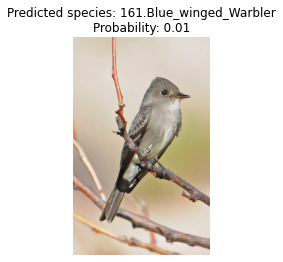

In [86]:
example_idx = random.randint(0, len(data))
example_label = data[data["id"]==example_idx]["species"].values[0]
example = Image.open("CUB_200_2011/images/" + data.loc[example_idx, "image_name"])
example_tensor = transform(example).unsqueeze(0).to(device)

with torch.no_grad():
    output = net(example_tensor)
    probabilities = F.softmax(output, dim=1)
    
pred_label = torch.argmax(probabilities).item()
pred_species = classes.loc[classes["label"]==pred_label]["species"].values[0]

print(f"The random index is {example_idx}")
print(f"The correct label is {example_label}")
display_prediction(example, pred_species, probabilities[0][pred_label].item())

### Need:
- Validation
- metrics
- Loss curve

### Validation

In [87]:
def cross_validation(net, dataset, k):
    fold_size = int(len(dataset) / k)
    folds = [dataset[i:i+fold_size] for i in range(0, len(dataset), fold_size)]
    print(folds)
    for i in range(k):
        train_data = [fold for j, fold in enumerate(folds) if j!=i]
        train_data = [item for sublist in train_data for item in sublist]
        trainset = CUBdata(train_data, transform=transform)
        trainloader = DataLoader(trainset, batch_size=4, shuffle=True)
        validate_data = folds[i]
        validateset = CUBdata(folds[i], transform=transform)
        valiloader = DataLoader(validateset, batch_size=4, shuffle=True)
        correct = 0
        total = 0
        acc = []
        with torch.no_grad():
            for teststat in valiloader:
                inputs, ytrue = teststat
                inputs, ytrue = inputs.to(device), ytrue.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += ytrue.size(0)
                correct += (predicted == ytrue).sum().item()
        acc.append(100 * correct / total)
        print('Accuracy of Fold %d the network on the %d test images: %d %%' % (i, len(validateset), 100 * correct / total))
    avg_acc = sum(acc) / len(acc)
    print('Average accuracy on all folds is %.3f' % avg_acc)
        

In [ ]:
cross_validation(net, train_data, 5)

### Metrics

In [91]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def report_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Precision: %.3f" % precision)
    print("Recall: %.3f " % recall)
    print("Confusion matrix:")
    print(conf_matrix)  

In [92]:
report_metrics(true_labels, predicted_labels)

Precision: 0.000
Recall: 0.006 
Confusion matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Loss Curve

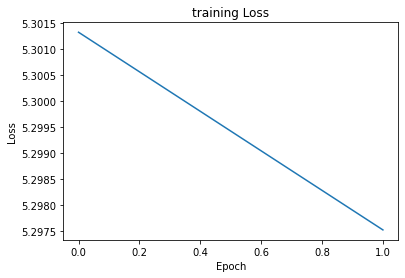

In [93]:
import matplotlib.pyplot as plt
plt.plot(avg_losses)
plt.title("training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Possible improvements:
on data processing: 
- binding box w/ parts
- zero padding to erase background <br>

on model:
- combine with transformer
- mask-CNN
-parameters, batchsize, optimizers, etc